# Predicting return from Gold

### Background


Gold has been the original store of value and medium of exchange for mankind for centuries till paper/or fiat currency took over a couple of centuries ago. However, most of the sustainable paper currencyies were backed by Gold as late as 1971, when the Bretton Woods agreement was scrapped and world currencies became a true $'Fiat'$ currency.

Gold however continues to be os interest not only as metal of choice for jewellery, but also as store of value and often advisable part of investment portfolio as it tends to be a hedge and safe haven when economies tend to (or atleat appear to) be in or at brink of collapse.

Currently there are numerous instruments which can give an investor exposure to Gold and they not necessarily need to keep it physically in their vaults. Exchange traded Funds (ETFs) is the most widely used instrument. As of April 2020, a total of **USD175bn** is invested in Gold ETFs across the globe. This was corpus was just **USD24bn in 2008** before the Global Financial Crisis (GFC)

### Approach

In the series we will take different approaches to predict return from Gold prices using Machine learning. We will use supervised learning methods of regression and classification. We will then use Time Series methods. And then finally we will try to integrate them to see of their predictive ppowers increases due to integration.

First we will go the regression route to predict future returns of Gold over next 2 weeks and 3 weeks period. We will do this by using historical returns of different instruments which I beleive impact or likely to impact the outlook towards Gold. The fundamental reason is, I term Gold as a 'reactionary' asset. It has little fundamentals of its own and movement in prices is often is a derivative of how investors view other asset classes (equities and commdities)

## Importing and Preparing Data

For this and subsequent exercises we will need closing price of several instruments for past 10 years . There are various paid (Reuters, Bloomberg) and free resources (IEX, Quandl, Yahoofinance, Google finance) that we can use to either extract and load data in csv or we can directly call their APIs. Since in this project I needed different type of asset classes (Equities, Commodities, Debt and precious metals) I found the 'yahoofinancials' package to be very helpful and straight forward. (https://pypi.org/project/yahoofinancials/)

In [1]:
#Importing Libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials

I have prepared a list instruments for which we need to import data. yahoofinancials package requires Yahoo ticker symbols. The list contains the ticker symbols and their descriptions. The excel file containing the list can be found here..... We import that file and extract the tciker symbols and the names as seprarate lists

In [2]:
ticker_details = pd.read_excel("Ticker List.xlsx")
ticker_details.head(20)

,Ticker,Description
0,GC=F,Gold
1,SI=F,Silver
2,CL=F,Crude Oil
3,^GSPC,S&P500
4,^RUT,Russel 2000 Index
5,ZN=F,10 Yr US T-Note futures
6,ZT=F,2 Yr US T-Note Futures
7,PL=F,Platinum
8,HG=F,Copper
9,DX=F,Dollar Index


In [3]:
ticker = ticker_details['Ticker'].to_list()
names = ticker_details['Description'].to_list()

Once we have the list, we need to define what date range we need to import the data for. The period I have chosen is Jan 2010 till 1st Mar 2020. The reason I did not pull data prior to that is because the GFC in 2008-09 massively changed the economic and market landscapes. Relationships pririo to that peirod might be of less relevance now. We also dont want to feed very less data as the models might tend to overfit.

We create a date-range and write it to an empty dataframe named values where we would extract and past the values we pull from yahoofinancials.

In [4]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
end_date= "2020-03-01"
start_date = "2010-01-01"
date_range = pd.bdate_range(start=start_date,end=end_date)
values = pd.DataFrame({ 'Date': date_range})
values['Date']= pd.to_datetime(values['Date'])

Once we have the date range in dataframe, we need to use ticker symbols to pull out data from the API. yahoofinancials returns the output in a JSON format. The following code loops over the the list of ticker symbols and extracts just the closing prices for all the historical dates and keeps them adding to the dataframe horizontally. Note I have used the merge function to mantain the sanctity of dates. Given these asset classes might have different regional and trading holidays, the date ranges are not bound to be the same. By merging, we will eventually have several NAs which we will frontfill later on.

In [5]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
for i in ticker:
    raw_data = YahooFinancials(i)
    raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
    df = pd.DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
    df.columns = ['Date1',i]
    df['Date1']= pd.to_datetime(df['Date1'])
    values = values.merge(df,how='left',left_on='Date',right_on='Date1')
    values = values.drop(labels='Date1',axis=1)

#Renaming columns to represent instrument names rather than their ticker codes for ease of readability
names.insert(0,'Date')
values.columns = names
print(values.shape)
print(values.isna().sum())
values.tail()

(2651, 17)
Date                         0
Gold                       117
Silver                     117
Crude Oil                  116
S&P500                      95
Russel 2000 Index           95
10 Yr US T-Note futures    118
2 Yr US T-Note Futures     116
Platinum                   117
Copper                     117
Dollar Index               121
Volatility Index            95
Soybean                    116
MSCI EM ETF                 95
Euro USD                   311
Euronext100                 55
Nasdaq                      95
dtype: int64


,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2646,2020-02-24,1672.400024,18.868000,51.430000,3225.889893,1628.099976,132.656006,108.273003,971.700012,2.5925,99.283997,25.030001,874.25,41.669998,1.083905,1120.449951,9221.280273
2647,2020-02-25,1646.900024,18.183001,49.900002,3128.209961,1571.900024,133.125000,108.398003,929.799988,2.5965,98.901001,27.850000,879.00,41.340000,1.084920,1099.270020,8965.610352
2648,2020-02-26,1640.000000,17.826000,48.730000,3116.389893,1552.760010,133.328003,108.480003,912.299988,2.5765,NaN,27.559999,881.00,41.669998,1.088200,1099.410034,8980.780273
2649,2020-02-27,1643.099976,17.799999,46.810001,2978.760010,1497.869995,133.218994,108.698997,904.299988,2.5690,NaN,39.160000,895.00,40.669998,1.088589,1059.359985,8566.480469
2650,2020-02-28,1642.500000,17.658001,47.090000,2954.219971,1476.430054,133.328003,108.773003,905.500000,2.5715,NaN,40.110001,891.75,40.520000,1.099723,1021.979980,8567.370117


In [6]:
#Front filling the NaN values in the data set
values = values.fillna(method="ffill",axis=0)
values = values.fillna(method="bfill",axis=0)
values.isna().sum()

Date                       0
Gold                       0
Silver                     0
Crude Oil                  0
S&P500                     0
Russel 2000 Index          0
10 Yr US T-Note futures    0
2 Yr US T-Note Futures     0
Platinum                   0
Copper                     0
Dollar Index               0
Volatility Index           0
Soybean                    0
MSCI EM ETF                0
Euro USD                   0
Euronext100                0
Nasdaq                     0
dtype: int64

In [7]:
# Co-ercing numeric type to all columns except Date
cols=values.columns.drop('Date')
values[cols] = values[cols].apply(pd.to_numeric,errors='coerce').round(decimals=1)
values.tail()

,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2646,2020-02-24,1672.4,18.9,51.4,3225.9,1628.1,132.7,108.3,971.7,2.6,99.3,25.0,874.2,41.7,1.1,1120.4,9221.3
2647,2020-02-25,1646.9,18.2,49.9,3128.2,1571.9,133.1,108.4,929.8,2.6,98.9,27.9,879.0,41.3,1.1,1099.3,8965.6
2648,2020-02-26,1640.0,17.8,48.7,3116.4,1552.8,133.3,108.5,912.3,2.6,98.9,27.6,881.0,41.7,1.1,1099.4,8980.8
2649,2020-02-27,1643.1,17.8,46.8,2978.8,1497.9,133.2,108.7,904.3,2.6,98.9,39.2,895.0,40.7,1.1,1059.4,8566.5
2650,2020-02-28,1642.5,17.7,47.1,2954.2,1476.4,133.3,108.8,905.5,2.6,98.9,40.1,891.8,40.5,1.1,1022.0,8567.4


In [8]:
values.to_csv("Training Data_Values.csv")

In approach we highlighted that we will used lagged returns of the listed instruments to predict future returns on Gold. Here we go on to calculate shortterm returns of all the instruments and longer term returns of few selected instruments. The fundamental idea behind it is, that if a certain asset has highly outperformed or underperformed, there is greater likelihood of portfolio rebalancing which would impact returns on other asset clasees. Eg: If the stock markets (S&P500) has shown stupendous returns in past 6 months, asset managers might want to book profits and allocate some funds to say precious metals and prepare for stock market correction. We will however, use Machine Learning to evaluate the hypothesis.

In [9]:
imp = ['Gold','Silver', 'Crude Oil', 'S&P500','MSCI EM ETF']
# Calculating Short term -Historical Returns
change_days = [1,3,5,14,21]

data = pd.DataFrame(data=values['Date'])
for i in change_days:
    print(data.shape)
    x= values[cols].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

# Calculating Long term Historical Returns
change_days = [60,90,180,250]

for i in change_days:
    print(data.shape)
    x= values[imp].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

(2651, 1)
(2651, 17)
(2651, 33)
(2651, 49)
(2651, 65)
(2651, 81)
(2651, 81)
(2651, 86)
(2651, 91)
(2651, 96)
(2651, 101)


Besides just the lagged returns, we also see how far the current Gold price is from its moving average for with different window. This is a very commonly used metric in technical analysis where moving averages offer supports and resistances for asset prices. We use a combination of simple and exponential moving averages. We then add these moving averages to the existing feature space.

In [10]:
#Calculating Moving averages for Gold
moving_avg = pd.DataFrame(values['Date'],columns=['Date'])
moving_avg['Date']=pd.to_datetime(moving_avg['Date'],format='%Y-%b-%d')
moving_avg['Gold/15SMA'] = (values['Gold']/(values['Gold'].rolling(window=15).mean()))-1
moving_avg['Gold/30SMA'] = (values['Gold']/(values['Gold'].rolling(window=30).mean()))-1
moving_avg['Gold/60SMA'] = (values['Gold']/(values['Gold'].rolling(window=60).mean()))-1
moving_avg['Gold/90SMA'] = (values['Gold']/(values['Gold'].rolling(window=90).mean()))-1
moving_avg['Gold/180SMA'] = (values['Gold']/(values['Gold'].rolling(window=180).mean()))-1
moving_avg['Gold/90EMA'] = (values['Gold']/(values['Gold'].ewm(span=90,adjust=True,ignore_na=True).mean()))-1
moving_avg['Gold/180EMA'] = (values['Gold']/(values['Gold'].ewm(span=180,adjust=True,ignore_na=True).mean()))-1
moving_avg = moving_avg.dropna(axis=0)
print(moving_avg.shape)
moving_avg.head()

(2472, 8)


,Date,Gold/15SMA,Gold/30SMA,Gold/60SMA,Gold/90SMA,Gold/180SMA,Gold/90EMA,Gold/180EMA
179,2010-09-09,0.005005,0.020246,0.026862,0.026428,0.067496,0.032506,0.046162
180,2010-09-10,0.000536,0.014916,0.023422,0.022489,0.063095,0.028204,0.041912
181,2010-09-13,0.000043,0.013705,0.023840,0.022565,0.062965,0.028040,0.041852
182,2010-09-14,0.017736,0.031368,0.043642,0.042295,0.083187,0.047219,0.061593
183,2010-09-15,0.013857,0.026901,0.040711,0.039604,0.079958,0.043701,0.058291


In [11]:
#Merging Moving Average values to the feature space
print(data.shape)
data['Date']=pd.to_datetime(data['Date'],format='%Y-%b-%d')
data = pd.merge(left=data,right=moving_avg,how='left',on='Date')
print(data.shape)
data.isna().sum()

(2651, 101)
(2651, 108)


Date               0
Gold-T-1           1
Silver-T-1         1
Crude Oil-T-1      1
S&P500-T-1         1
                ... 
Gold/60SMA       179
Gold/90SMA       179
Gold/180SMA      179
Gold/90EMA       179
Gold/180EMA      179
Length: 108, dtype: int64

This wall all about features. Now we need to create targets, i.e what we want to predict. Since we are predicting returns, we need to pick a horizon for which we need to predict returns. I have chosen 14-day and 22-day horizons because other smaller horizons tend to be very volatile and lack and predictive power. One can however, experiment with other horizons as well.

In [12]:
#Caluculating forward returns for Target
y = pd.DataFrame(data=values['Date'])
print(y.shape)
y['Gold-T+14']=values["Gold"].pct_change(periods=-14)
y['Gold-T+22']=values["Gold"].pct_change(periods=-22)
print(y.shape)
y.isna().sum()

(2651, 1)
(2651, 3)


Date          0
Gold-T+14    14
Gold-T+22    22
dtype: int64

In [13]:
# Removing NAs
print(data.shape)
data = data[data['Gold-T-250'].notna()]
y = y[y['Gold-T+22'].notna()]
print(data.shape)
print(y.shape)

(2651, 108)
(2401, 108)
(2629, 3)


Now we will merge the Target variables with the feature space to get a data whcih we can finally start modelling on.

In [14]:
#Adding Target Variables
data = pd.merge(left=data,right=y,how='inner',on='Date',suffixes=(False,False))
print(data.shape)
data.isna().sum()

(2379, 110)


Date             0
Gold-T-1         0
Silver-T-1       0
Crude Oil-T-1    0
S&P500-T-1       0
                ..
Gold/180SMA      0
Gold/90EMA       0
Gold/180EMA      0
Gold-T+14        0
Gold-T+22        0
Length: 110, dtype: int64

In [16]:
data.to_csv("Training Data.csv",index=False)

In [17]:
corr = data.corr().iloc[:,-2:].drop(labels=['Gold-T+14','Gold-T+22'],axis=0)

In [18]:
import seaborn as sns
import numpy as np

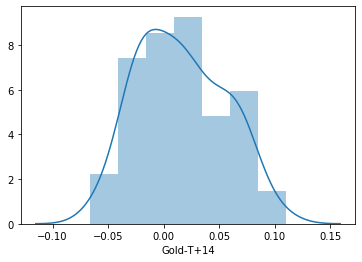

In [19]:
sns.distplot(corr.iloc[:,0])

In [20]:
pd.set_option('display.max_rows', None)
corr_data = data.tail(2000).corr()
corr_data = pd.DataFrame(corr_data['Gold-T+14'])
#corr_data = corr_data.iloc[3:,]
corr_data = corr_data.sort_values('Gold-T+14',ascending=False)
#corr_data

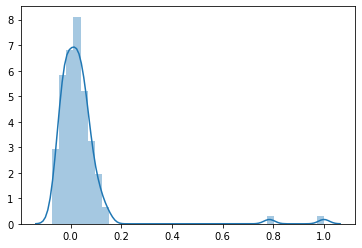

In [21]:
sns.distplot(corr_data)

# Regression

## 22 Day Model

In [22]:
#data = pd.read_csv("Training Data.csv")

In [23]:
from pycaret.regression import *

In [24]:
data_22= data.drop(['Gold-T+14'],axis=1)
data_22.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,...,S&P500-T-250,MSCI EM ETF-T-250,Gold/15SMA,Gold/30SMA,Gold/60SMA,Gold/90SMA,Gold/180SMA,Gold/90EMA,Gold/180EMA,Gold-T+22
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,...,0.097882,0.092219,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0.007675
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,...,0.100706,0.086455,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0.011166
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,...,0.103916,0.097421,-0.002386,0.006090,0.017567,0.044925,0.097391,0.040811,0.075992,0.030969
3,2010-12-22,-0.001009,0.000000,0.007795,0.003348,0.000127,-0.009901,0.000000,0.005227,0.00000,...,0.107027,0.097143,-0.003368,0.005374,0.015569,0.042501,0.095189,0.038850,0.073962,0.034154
4,2010-12-23,-0.004903,-0.003401,0.011050,-0.001589,-0.002024,-0.003333,0.000000,-0.004506,0.00000,...,0.100815,0.103448,-0.007851,0.001003,0.009699,0.036124,0.088766,0.032987,0.067834,0.026404


In [25]:
a=setup(data_22,target='Gold-T+22',
        ignore_features=['Date'],session_id=11,
        silent=True,profile=False,remove_outliers=False);
        #transformation=True,
        #pca=True,pca_method='kernel',
        #pca_components=10,
        #create_clusters=True,
        #cluster_iter=10,
        #feature_ratio=True,
        #normalize=True,
        #transform_target=True,
       #silent=True);

 
Setup Succesfully Completed!


,Description,Value
0,session_id,11
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(2379, 109)"
4,Missing Values,False
5,Numeric Features,107
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [26]:
compare_models(blacklist=['tr','ard'],turbo=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0123,0.0003,0.0166,0.8566,0.0152,-0.0001
1,CatBoost Regressor,0.0133,0.0003,0.0176,0.839,0.0161,0.0062
2,Light Gradient Boosting Machine,0.0136,0.0003,0.0182,0.8293,0.0163,-0.0619
3,K Neighbors Regressor,0.0132,0.0003,0.0181,0.8287,0.0154,-0.0419
4,Random Forest,0.0153,0.0004,0.0207,0.7773,0.0188,-0.0707
5,Gradient Boosting Regressor,0.0202,0.0007,0.0264,0.6389,0.0239,0.0169
6,Extreme Gradient Boosting,0.0203,0.0007,0.0266,0.632,0.0243,-0.037
7,Decision Tree,0.0216,0.0011,0.0327,0.4396,0.0238,0.2117
8,AdaBoost Regressor,0.0296,0.0014,0.037,0.2858,0.0327,0.0721
9,Bayesian Ridge,0.0302,0.0016,0.0399,0.1723,0.0331,-0.1529


In [27]:
knn_tuned = tune_model('knn',n_iter=150)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0110,0.0002,0.0151,0.8638,0.0127,0.8436
1,0.0109,0.0002,0.0147,0.8506,0.0132,-1.3088
2,0.0125,0.0004,0.0192,0.8356,0.0157,-0.1460
3,0.0109,0.0003,0.0177,0.8343,0.0132,-0.2875
4,0.0095,0.0002,0.0123,0.9179,0.0112,0.1779
5,0.0109,0.0003,0.0161,0.8694,0.0144,-0.6335
6,0.0113,0.0002,0.0155,0.8981,0.0140,0.1330
7,0.0129,0.0004,0.0200,0.8458,0.0164,0.1446
8,0.0105,0.0002,0.0146,0.8760,0.0126,1.1573
9,0.0089,0.0002,0.0124,0.9111,0.0111,-0.6811


In [28]:
catb_tuned = tune_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0123,0.0003,0.0163,0.8420,0.0153,0.1108
1,0.0129,0.0003,0.0173,0.7930,0.0152,-1.1842
2,0.0155,0.0004,0.0207,0.8098,0.0185,-0.4919
3,0.0145,0.0003,0.0185,0.8195,0.0169,0.5177
4,0.0125,0.0003,0.0169,0.8451,0.0155,0.2538
5,0.0130,0.0003,0.0166,0.8614,0.0150,-0.5117
6,0.0140,0.0003,0.0184,0.8554,0.0163,0.4126
7,0.0163,0.0005,0.0219,0.8158,0.0197,-0.0303
8,0.0140,0.0003,0.0185,0.8002,0.0168,0.9556
9,0.0127,0.0003,0.0168,0.8356,0.0153,-0.5128


In [29]:
et_tuned = tune_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0158,0.0005,0.0213,0.7290,0.0198,0.0144
1,0.0126,0.0003,0.0173,0.7928,0.0159,-0.2783
2,0.0164,0.0005,0.0224,0.7757,0.0204,-0.1512
3,0.0161,0.0005,0.0216,0.7526,0.0202,1.5357
4,0.0130,0.0003,0.0182,0.8206,0.0171,0.0500
5,0.0153,0.0004,0.0211,0.7765,0.0197,-0.4171
6,0.0159,0.0005,0.0220,0.7934,0.0203,0.1038
7,0.0187,0.0006,0.0255,0.7501,0.0227,0.0165
8,0.0145,0.0004,0.0199,0.7690,0.0184,0.3568
9,0.0137,0.0003,0.0185,0.8019,0.0171,-0.5919


In [30]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0125,0.0003,0.0172,0.8245,0.0160,0.2454
1,0.0101,0.0002,0.0138,0.8676,0.0125,-0.3486
2,0.0135,0.0003,0.0182,0.8530,0.0163,-0.0782
3,0.0133,0.0003,0.0174,0.8407,0.0160,0.4918
4,0.0103,0.0002,0.0139,0.8958,0.0130,0.1053
5,0.0124,0.0003,0.0167,0.8604,0.0153,-0.4653
6,0.0129,0.0003,0.0183,0.8581,0.0162,0.2026
7,0.0151,0.0004,0.0203,0.8412,0.0184,-0.0147
8,0.0119,0.0003,0.0161,0.8497,0.0148,0.3478
9,0.0107,0.0002,0.0147,0.8748,0.0138,-0.4870


In [31]:
evaluate_model(knn_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [32]:
evaluate_model(et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [33]:
b=setup(data_22,target='Gold-T+22',
        ignore_features=['Date'],session_id=11,
        silent=True,profile=False,remove_outliers=True);
        #transformation=True,
        #pca=True,pca_method='kernel',
        #pca_components=10,
        #create_clusters=True,
        #cluster_iter=10,
        #feature_ratio=True,
        #normalize=True,
        #transform_target=True,
       #silent=True);

 
Setup Succesfully Completed!


,Description,Value
0,session_id,11
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(2379, 109)"
4,Missing Values,False
5,Numeric Features,107
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [34]:
knn_tuned = tune_model('knn',n_iter=150)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0095,0.0001,0.0122,0.9179,0.0111,0.0006
1,0.0099,0.0002,0.0133,0.9131,0.0116,-0.4387
2,0.0118,0.0003,0.0177,0.8465,0.0148,1.6218
3,0.0103,0.0003,0.0158,0.8750,0.0146,-0.5072
4,0.0107,0.0002,0.0149,0.8696,0.0135,0.0413
5,0.0109,0.0002,0.0153,0.8994,0.0129,1.5195
6,0.0104,0.0002,0.0150,0.8531,0.0132,0.2987
7,0.0104,0.0002,0.0149,0.8931,0.0128,-0.1118
8,0.0109,0.0002,0.0148,0.8914,0.0135,0.2823
9,0.0104,0.0002,0.0152,0.8705,0.0131,-0.3342


In [35]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0119,0.0002,0.0155,0.8661,0.0147,0.0149
1,0.0123,0.0003,0.0161,0.8739,0.0149,-0.2347
2,0.0127,0.0003,0.0172,0.8555,0.0161,0.8219
3,0.0116,0.0003,0.0165,0.8641,0.0154,-0.3188
4,0.0122,0.0003,0.0162,0.8470,0.0151,-0.1451
5,0.0143,0.0004,0.0197,0.8340,0.0181,1.2198
6,0.0106,0.0002,0.0145,0.8629,0.0135,0.1561
7,0.0124,0.0003,0.0169,0.8629,0.0152,-0.6990
8,0.0123,0.0003,0.0163,0.8680,0.0152,0.2193
9,0.0111,0.0002,0.0145,0.8811,0.0135,-0.4825


In [36]:
catb = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0130,0.0003,0.0167,0.8449,0.0155,0.0242
1,0.0134,0.0003,0.0173,0.8541,0.0157,-0.4452
2,0.0133,0.0003,0.0176,0.8486,0.0164,0.5892
3,0.0125,0.0003,0.0177,0.8428,0.0166,-0.5235
4,0.0130,0.0003,0.0170,0.8303,0.0157,-0.2354
5,0.0155,0.0005,0.0215,0.8024,0.0199,1.2039
6,0.0117,0.0003,0.0158,0.8360,0.0139,0.3065
7,0.0133,0.0003,0.0184,0.8383,0.0163,-0.4717
8,0.0136,0.0003,0.0177,0.8454,0.0162,0.3077
9,0.0119,0.0002,0.0152,0.8701,0.0139,-0.7064


### Ensembling Models

In [37]:
et_bagged = ensemble_model(et,method='Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0153,0.0004,0.0199,0.7814,0.0186,-0.0270
1,0.0158,0.0004,0.0203,0.7993,0.0190,-0.1741
2,0.0156,0.0004,0.0210,0.7840,0.0197,1.1660
3,0.0153,0.0005,0.0215,0.7680,0.0202,-0.3361
4,0.0143,0.0004,0.0192,0.7850,0.0180,-0.0785
5,0.0171,0.0006,0.0238,0.7573,0.0219,0.8438
6,0.0135,0.0003,0.0184,0.7790,0.0173,0.0382
7,0.0160,0.0005,0.0215,0.7777,0.0196,-0.7169
8,0.0155,0.0004,0.0210,0.7812,0.0197,0.2102
9,0.0145,0.0003,0.0186,0.8065,0.0173,-0.5303


In [38]:
knn_tuned_bagged = ensemble_model(knn_tuned, method='Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0101,0.0002,0.0127,0.9105,0.0117,0.0624
1,0.0097,0.0002,0.0127,0.9211,0.0109,-0.2473
2,0.0113,0.0003,0.0159,0.8762,0.0133,1.0833
3,0.0102,0.0002,0.0142,0.8996,0.0129,-0.4496
4,0.0107,0.0002,0.0142,0.8822,0.0127,0.0291
5,0.0120,0.0003,0.0165,0.8834,0.0143,1.3016
6,0.0109,0.0002,0.0149,0.8556,0.0131,0.4445
7,0.0104,0.0003,0.0159,0.8781,0.0137,-0.4300
8,0.0111,0.0002,0.0147,0.8938,0.0137,0.3251
9,0.0110,0.0003,0.0165,0.8470,0.0138,1.0056


### Blending Models

In [39]:
blend_knn_et = blend_models(estimator_list=[knn_tuned,et])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0091,0.0001,0.0117,0.9242,0.0110,-0.0276
1,0.0099,0.0002,0.0129,0.9194,0.0114,-0.2974
2,0.0104,0.0002,0.0149,0.8907,0.0134,0.3463
3,0.0100,0.0002,0.0143,0.8973,0.0133,-0.4047
4,0.0099,0.0002,0.0132,0.8976,0.0122,-0.1032
5,0.0112,0.0002,0.0158,0.8934,0.0139,1.3464
6,0.0097,0.0002,0.0131,0.8878,0.0120,0.1625
7,0.0100,0.0002,0.0141,0.9048,0.0124,-0.4644
8,0.0102,0.0002,0.0137,0.9068,0.0128,0.2877
9,0.0096,0.0002,0.0134,0.8992,0.0120,-0.4828


In [40]:
stack1 = create_stacknet(estimator_list=[[catb,knn_tuned],[et,blend_knn_et]],restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0089,0.0001,0.0116,0.9255,0.0104,0.1044
1,0.0096,0.0002,0.0129,0.9194,0.0115,-0.8035
2,0.0113,0.0003,0.0158,0.8771,0.0139,0.9680
3,0.0108,0.0002,0.0155,0.8793,0.0145,-0.6445
4,0.0100,0.0002,0.0138,0.8887,0.0126,-0.2210
5,0.0107,0.0002,0.0148,0.9063,0.0135,1.1534
6,0.0097,0.0002,0.0129,0.8915,0.0116,0.3532
7,0.0099,0.0002,0.0143,0.9012,0.0126,-0.3576
8,0.0102,0.0002,0.0139,0.9039,0.0125,0.3768
9,0.0092,0.0002,0.0124,0.9136,0.0110,-0.6674


In [41]:
stack2 = create_stacknet(estimator_list=[[catb,et,knn_tuned],[blend_knn_et]], restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0085,0.0001,0.0109,0.9336,0.0101,-0.0193
1,0.0089,0.0001,0.0120,0.9295,0.0108,-0.6780
2,0.0100,0.0002,0.0142,0.9011,0.0130,0.4720
3,0.0105,0.0002,0.0144,0.8966,0.0135,-0.8603
4,0.0099,0.0002,0.0136,0.8922,0.0125,-0.1852
5,0.0105,0.0002,0.0145,0.9099,0.0130,1.1676
6,0.0092,0.0001,0.0122,0.9023,0.0111,0.1212
7,0.0093,0.0002,0.0136,0.9115,0.0121,-0.4792
8,0.0093,0.0002,0.0129,0.9173,0.0118,0.2953
9,0.0088,0.0001,0.0115,0.9257,0.0104,-1.0905


In [42]:
stack3 = create_stacknet(estimator_list=[[catb,et,knn_tuned],[blend_knn_et]], restack=True,meta_model=blend_knn_et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0085,0.0001,0.0108,0.9351,0.0101,-0.0613
1,0.0090,0.0001,0.0122,0.9270,0.0105,-0.4676
2,0.0103,0.0002,0.0149,0.8908,0.0132,0.8496
3,0.0098,0.0002,0.0147,0.8916,0.0137,-0.5214
4,0.0099,0.0002,0.0135,0.8942,0.0122,-0.1646
5,0.0099,0.0002,0.0135,0.9220,0.0119,1.4394
6,0.0094,0.0002,0.0131,0.8878,0.0118,0.2767
7,0.0099,0.0002,0.0141,0.9048,0.0124,-0.4634
8,0.0096,0.0002,0.0126,0.9211,0.0118,0.3070
9,0.0091,0.0002,0.0129,0.9064,0.0114,-0.4695


In [43]:
save_model(model=stack2, model_name='22Day Regressor')

Transformation Pipeline and Model Succesfully Saved


### 14 Day Model 

In [44]:
data_14= data.drop(['Gold-T+22'],axis=1)
data_14.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,...,S&P500-T-250,MSCI EM ETF-T-250,Gold/15SMA,Gold/30SMA,Gold/60SMA,Gold/90SMA,Gold/180SMA,Gold/90EMA,Gold/180EMA,Gold-T+14
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,...,0.097882,0.092219,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0.005250
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,...,0.100706,0.086455,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0.012422
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,...,0.103916,0.097421,-0.002386,0.006090,0.017567,0.044925,0.097391,0.040811,0.075992,0.010555
3,2010-12-22,-0.001009,0.000000,0.007795,0.003348,0.000127,-0.009901,0.000000,0.005227,0.00000,...,0.107027,0.097143,-0.003368,0.005374,0.015569,0.042501,0.095189,0.038850,0.073962,0.002023
4,2010-12-23,-0.004903,-0.003401,0.011050,-0.001589,-0.002024,-0.003333,0.000000,-0.004506,0.00000,...,0.100815,0.103448,-0.007851,0.001003,0.009699,0.036124,0.088766,0.032987,0.067834,-0.004113


In [45]:
c=setup(data_14,target='Gold-T+14',
        ignore_features=['Date'],session_id=11,
        silent=True,profile=False,remove_outliers=True);
        #transformation=True,
        #pca=True,pca_method='kernel',
        #pca_components=10,
        #create_clusters=True,
        #cluster_iter=10,
        #feature_ratio=True,
        #normalize=True,
        #transform_target=True,
       #silent=True);

 
Setup Succesfully Completed!


,Description,Value
0,session_id,11
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(2379, 109)"
4,Missing Values,False
5,Numeric Features,107
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [46]:
compare_models(blacklist=['tr','ard'],turbo=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0117,0.0003,0.0158,0.8017,0.0147,0.0074
1,CatBoost Regressor,0.0122,0.0003,0.0165,0.7834,0.0151,-0.0629
2,K Neighbors Regressor,0.0124,0.0003,0.0172,0.7615,0.0147,-0.1314
3,Light Gradient Boosting Machine,0.0127,0.0003,0.0173,0.7602,0.0154,-0.0754
4,Random Forest,0.0143,0.0004,0.0196,0.695,0.0177,-0.0375
5,Gradient Boosting Regressor,0.0175,0.0005,0.0231,0.5782,0.0208,-0.0719
6,Extreme Gradient Boosting,0.018,0.0006,0.0239,0.5472,0.0215,-0.0641
7,Decision Tree,0.0199,0.0009,0.0298,0.2763,0.0204,-0.0721
8,AdaBoost Regressor,0.0242,0.0009,0.0307,0.2517,0.0284,0.0746
9,Bayesian Ridge,0.0251,0.0011,0.0336,0.1075,0.028,-0.0262


In [47]:
knn_tuned = tune_model('knn',n_iter=150)
catb = create_model('catboost')
et = create_model('et')
knn_tuned_bagged = ensemble_model(knn_tuned, method='Bagging')
blend_knn_et = blend_models(estimator_list=[knn_tuned,et])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0099,0.0002,0.0127,0.8708,0.0116,-0.1175
1,0.0095,0.0002,0.0131,0.8786,0.0121,0.1219
2,0.0092,0.0001,0.0120,0.8984,0.0114,-0.2084
3,0.0094,0.0002,0.0133,0.8557,0.0110,0.1131
4,0.0096,0.0002,0.0124,0.8578,0.0112,-1.8463
5,0.0111,0.0002,0.0155,0.8409,0.0138,-0.1782
6,0.0098,0.0002,0.0127,0.8419,0.0118,0.0718
7,0.0089,0.0001,0.0120,0.8853,0.0110,-0.5482
8,0.0089,0.0001,0.0118,0.8784,0.0107,0.1812
9,0.0098,0.0002,0.0136,0.8648,0.0123,0.0160


In [48]:
stack1 = create_stacknet(estimator_list=[[catb,knn_tuned],[et,blend_knn_et]],restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0092,0.0001,0.0122,0.8816,0.0109,-0.2419
1,0.0090,0.0002,0.0124,0.8909,0.0111,-0.0291
2,0.0084,0.0001,0.0108,0.9178,0.0102,-0.2251
3,0.0086,0.0002,0.0125,0.8731,0.0091,0.3260
4,0.0095,0.0002,0.0128,0.8493,0.0107,-1.6658
5,0.0112,0.0003,0.0160,0.8311,0.0139,-0.1761
6,0.0092,0.0001,0.0121,0.8571,0.0110,0.0658
7,0.0085,0.0001,0.0118,0.8889,0.0107,-0.2962
8,0.0095,0.0002,0.0133,0.8466,0.0116,0.2207
9,0.0097,0.0002,0.0134,0.8700,0.0120,-0.1283


In [49]:
stack2 = create_stacknet(estimator_list=[[catb,et,knn_tuned],[blend_knn_et]], restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0092,0.0001,0.0119,0.8875,0.0107,-0.1157
1,0.0088,0.0001,0.0118,0.9005,0.0107,0.1077
2,0.0083,0.0001,0.0104,0.9241,0.0097,-0.1060
3,0.0086,0.0002,0.0125,0.8725,0.0093,0.3352
4,0.0094,0.0001,0.0121,0.8649,0.0109,-1.4615
5,0.0111,0.0003,0.0159,0.8340,0.0138,-0.1595
6,0.0087,0.0001,0.0114,0.8728,0.0103,0.0573
7,0.0084,0.0001,0.0117,0.8916,0.0107,-0.2418
8,0.0089,0.0002,0.0125,0.8636,0.0110,0.1652
9,0.0091,0.0002,0.0125,0.8861,0.0113,-0.1404


In [50]:
stack3 = create_stacknet(estimator_list=[[catb,et,knn_tuned],[blend_knn_et]], restack=True,meta_model=blend_knn_et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0087,0.0001,0.0113,0.8982,0.0101,-0.1540
1,0.0087,0.0001,0.0118,0.9013,0.0108,0.1448
2,0.0086,0.0001,0.0112,0.9113,0.0106,-0.3816
3,0.0088,0.0002,0.0127,0.8686,0.0094,0.2068
4,0.0092,0.0001,0.0121,0.8648,0.0106,-2.5202
5,0.0107,0.0002,0.0150,0.8518,0.0131,-0.2686
6,0.0089,0.0001,0.0121,0.8570,0.0109,0.1323
7,0.0082,0.0001,0.0114,0.8975,0.0106,-0.6362
8,0.0090,0.0002,0.0127,0.8596,0.0111,0.2336
9,0.0093,0.0002,0.0134,0.8692,0.0118,0.0342


In [51]:
save_model(model=stack2, model_name='14Day Regressor')

Transformation Pipeline and Model Succesfully Saved
